In [13]:
#[코드 분리]Kruskal-Wallis Test - 누적 사망자 치명률 + 3월 중순 이후 데이터 버전
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from decimal import Decimal

In [14]:
#by_60211642
data = pd.read_csv("./코로나바이러스감염증-19_확진환자_발생현황_221126.csv", header = 0)
data.tail(10)

일자         계(명)      국내발생(명)  해외유입(명)    사망(명)  Unnamed: 5  열2  \
1033  2022.11.18      49,399       49,333       66        63         NaN NaN   
1034  2022.11.19      50,568       50,518       50        65         NaN NaN   
1035  2022.11.20      45,998       45,940       58        41         NaN NaN   
1036  2022.11.21      23,077       23,016       61        35         NaN NaN   
1037  2022.11.22      72,860       72,779       81        45         NaN NaN   
1038  2022.11.23      70,306       70,237       69        53         NaN NaN   
1039  2022.11.24      59,082       59,027       55        59         NaN NaN   
1040  2022.11.25      53,698       53,659       39        55         NaN NaN   
1041  2022.11.26      52,788       52,726       62        52         NaN NaN   
1042       누적(명)  26,890,488   26,819,311   71,177   30,330          NaN NaN   

      열3  열4  열5  Unnamed: 10  Unnamed: 11  
1033 NaN NaN NaN          NaN          NaN  
1034 NaN NaN NaN          NaN          NaN  
1035 NaN NaN NaN          NaN          NaN  
1036 NaN NaN NaN          NaN          NaN  
1037 NaN NaN NaN          NaN          NaN  
1038 NaN NaN NaN          NaN          NaN  
1039 NaN NaN NaN          NaN          NaN  
1040 NaN NaN NaN          NaN          NaN  
1041 NaN NaN NaN          NaN          NaN  
1042 NaN NaN NaN          NaN          NaN

In [10]:
# 맥 개발환경 한국어 설정을 위함.
import matplotlib as mpl
#by_60211642
print(mpl.matplotlib_fname())

# 맥 개발환경 한국어 설정을 위함.
font_path="./NanumGothicBold.ttf"
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
#by_60211642

/Users/jieunsong/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [18]:
df_covid = data.loc[:,['일자','계(명)','사망(명)']][:1042]
df_covid3 = data.loc[:,['일자','계(명)','사망(명)']][57:1042]
df_accumulate = data.loc[:,['일자','계(명)','사망(명)']][1042:1043] 

df_covid.isna().sum()
df_covid = df_covid.replace("-", 0).set_index('일자')

In [19]:
#누적 확진자 수 구하는 코드
df_covid["누적 확진자 수"] = df_covid["계(명)"]
def cumulative_number(i):
    if i == 0:
        df_covid["누적 확진자 수"][0] = int(df_covid["계(명)"][0])
    else:
        if type(df_covid["계(명)"][i]) != int :
            p = df_covid["계(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_covid["계(명)"][i] = int(str_confirmed)
            
        df_covid["누적 확진자 수"][i] = int(df_covid["누적 확진자 수"][i-1]) + df_covid["계(명)"][i]

for i in range(len(df_covid)):
    cumulative_number(i)

In [20]:
#누적 사망자 수 구하는 코드
df_covid["누적 사망자 수"] = df_covid["계(명)"]
def cumulative_number2(i):
    if i == 0:
        df_covid["누적 사망자 수"][0] = int(df_covid["사망(명)"][0])
    else:
        if type(df_covid["사망(명)"][i]) != int :
            p = df_covid["사망(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_covid["사망(명)"][i] = int(str_confirmed)
            
        df_covid["누적 사망자 수"][i] = int(df_covid["누적 사망자 수"][i-1]) + df_covid["사망(명)"][i]

for i in range(len(df_covid)):
    cumulative_number2(i)

In [21]:
#감염률 구하는 코드
df_covid["감염률"] = df_covid["계(명)"]
def infection_rate(i):
    rok_pop = 51628117
    if i == 0:
        df_covid["감염률"][0] = int(df_covid["계(명)"][0])/rok_pop
    else:
        #분모 (전체 국민 - 당일의 누적 확진자 수)
        denominator = (rok_pop - df_covid["누적 확진자 수"][i-1])
        #분자 (당일의 확진자 수)
        numerator = df_covid["계(명)"][i]
        p_infection = numerator/denominator
        df_covid["감염률"][i] = p_infection
            
    
for i in range(len(df_covid)):
    infection_rate(i)

In [22]:
#치명률 구하는 코드
df_covid["치명률"] = df_covid["누적 사망자 수"]
def death_rate(i):
    if i <17:
        #이러면 초기 17일 치명률은 또 outlier 처리 필요함. (by60211642) -> 왜? : 치명률이 이미 들어간 상태로 결과 값이 나와 있는데 
        # 이전의 치명률이기 때문에 잘라야함.
        df_covid["치명률"][0] = 0
    else:
        #분자 (누적 사망자 수)
        #분모 (17일 전 누적 확진자 수)
        p_lethality = int(df_covid["누적 사망자 수"][i])/int(df_covid["누적 확진자 수"][i-17])
        df_covid["치명률"][i] = p_lethality
            
    
for i in range(len(df_covid)):
    death_rate(i)

In [24]:
#column 이름 명확하게 바꿈 (by60211642)
df_covid.rename(columns = {'계(명)':'일일 확진자 수'}, inplace=True)
df_covid.rename(columns = {'사망(명)':'일일 사망자 수'}, inplace=True)

# 신천지 집단 감염 사태와 코로나 유행 초기인 걸 생각했을 때 앞부분 데이터가 신뢰도가 떨어질 것.
# 신천지 사태 한 달 후인 3월 17일 이후 데이터만 사용하는게 치명률에서 이상치를 줄일 수 있을 것이라 생각.
# 이름이 의미를 가지게 수정(by60211642)
df_covid_rmOutlier = df_covid.loc['2020.3.17':]
df_covid_rmOutlier.head(10)

일일 확진자 수 일일 사망자 수 누적 확진자 수 누적 사망자 수       감염률       치명률
일자                                                               
2020.3.17       84        6     8320       81  0.000002  0.027636
2020.3.18       93        3     8413       84  0.000002  0.023823
2020.3.19      152        7     8565       91  0.000003  0.021605
2020.3.20       87        3     8652       94  0.000002  0.019534
2020.3.21      147        8     8799      102  0.000003  0.019144
2020.3.22       98        2     8897      104  0.000002  0.018037
2020.3.23       64        7     8961      111  0.000001  0.017664
2020.3.24       76        9     9037      120  0.000001  0.017733
2020.3.25      100        6     9137      126  0.000002  0.017662
2020.3.26      104        5     9241      131  0.000002  0.017746

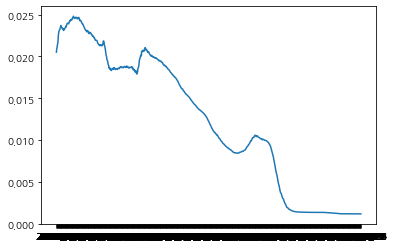

In [25]:
#치명률 그래프로 확인
plt.plot(df_covid3['일자'][16:], df_covid_rmOutlier['치명률'][16:])
plt.show()

#우세종에 따른 데이터 구간 나누기 -> 기타, delta, omi 이렇게 3가지로 나눴음. 결국은 초기 치명률은 outlier
#: 우리가 본 data에서는 신천지 집단 감염 때문에 나왔기 때문에 제거 필요. (by 60211642) -> 우리 data에서는 유의미하게 값이 달라지지는 않음
df_covid_etc = df_covid_rmOutlier.loc['2020.4.2':"2021.7.31"]
df_covid_delta = df_covid_rmOutlier.loc["2021.8.1":"2022.1.24"]
df_covid_omi = df_covid_rmOutlier.loc["2022.1.25":]

In [31]:
#1 감염률 데이터 분석 
#타입변환
df_covid_etc = df_covid_etc.astype({'감염률' : 'float'})
df_covid_delta = df_covid_delta.astype({'감염률' : 'float'})
df_covid_omi = df_covid_omi.astype({'감염률' : 'float'})

In [30]:
#정규성 검증
print("[1. 감염률 데이터 분석]")
print("[감염률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()
print("[감염률 등분산 검증]")
# 정규분포 아닐 시 bartlett사용 불가 -> non-parametric method인 fligner test 사용(by 60211642)
test_stat, p_val = stats.fligner(df_covid_etc["감염률"],df_covid_delta["감염률"],df_covid_omi["감염률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()
#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
#ks test
print("[감염률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["감염률"], df_covid_delta["감염률"], df_covid_omi["감염률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

[1. 감염률 데이터 분석]
[감염률 정규성 검증]
Shapiro Test-statistics : 0.8539105653762817, p-value : 7.790196369742615e-21
Shapiro Test-statistics : 0.835544228553772, p-value : 7.48299046424844e-13
Shapiro Test-statistics : 0.805178165435791, p-value : 7.125169911372918e-19

[감염률 등분산 검증]
Fligner Test-statistics : 683.7901745808464, p-value : 3.2873822050209747e-149

[감염률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 804.3463264524516, p-value : 2.1797889228493447e-175



In [32]:
#2 치명률 데이터 분석 
print("[2. 치명률 데이터 분석]")
#타입변환
df_covid_etc = df_covid_etc.astype({'치명률' : 'float'})
df_covid_delta = df_covid_delta.astype({'치명률' : 'float'})
df_covid_omi = df_covid_omi.astype({'치명률' : 'float'})

#정규성 검증
print("[치명률 정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#등분산 검증
print("[치명률 등분산 검증]")
# 정규분포 아닐 시 bartlett사용 불가 -> non-parametric method인 fligner test 사용(by 60211642)
test_stat, p_val = stats.fligner(df_covid_etc["치명률"],df_covid_delta["치명률"],df_covid_omi["치명률"])
print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))

#정규성을 만족하지 않으므로 Kruskal-Wallis Test 실행
#ks test
print("[치명률 Kruskal-Wallis Test]")
test_stat, p_val = stats.kruskal(df_covid_etc["치명률"], df_covid_delta["치명률"], df_covid_omi["치명률"])
print("Kruskal-Wallis Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

[2. 치명률 데이터 분석]
[치명률 정규성 검증]
Shapiro Test-statistics : 0.9608435034751892, p-value : 4.450002033529188e-10
Shapiro Test-statistics : 0.9434995055198669, p-value : 1.8121364746548352e-06
Shapiro Test-statistics : 0.5536781549453735, p-value : 3.1924320684309763e-27

[치명률 등분산 검증]
Fligner Test-statistics : 148.9384212608489, p-value : 4.554416576790575e-33
[치명률 Kruskal-Wallis Test]
Kruskal-Wallis Test-statistics : 798.2136625406547, p-value : 4.678487671713772e-174

